# 📘 Feature Extraction with Eigen Face

## 🔎 Introduction
In the previous notebook, we prepared our dataset by:
- Converting images into grayscale  
- Resizing them into a fixed size (100×100)  
- Flattening into vectors of length 10,000  
- Normalizing pixel intensities  

While this ensures uniformity, the data is still **high-dimensional** (10,000 features per image).  
Working directly on such large vectors can be:
- **Computationally expensive**  
- **Prone to overfitting**  
- **Difficult to interpret**  

To overcome this, we will apply **Principal Component Analysis (PCA)**, also known as the **Eigenfaces method**, to extract the most significant facial features.

---

## 🎯 Objectives
1. **Understand Eigenfaces Concept**  
   - Represent faces using a smaller set of principal components.  
   - Capture the key variations between faces while ignoring noise.  

2. **Dimensionality Reduction**  
   - Reduce each 10,000-dimensional image vector into a manageable size (e.g., 100–200 features).  
   - Improve efficiency for training classification models.  

3. **Visualization of Eigenfaces**  
   - Show the first few Eigenfaces (principal components) as images.  
   - Understand how each component contributes to representing faces.  

4. **Feature Extraction for Classification**  
   - Transform all face images into their **PCA feature representation**.  
   - Prepare this reduced feature dataset for building machine learning models (e.g., gender classification).  

---

✅ By the end of this notebook, we will have **compressed yet informative features** for each face image, ready to be used in classification tasks.  


In [3]:
# 📦 Import Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Eigenfaces with PCA
from sklearn.decomposition import PCA 

# Save & Load processed data
import pickle


In [4]:
# 📂 Load Preprocessed Data

# Load the dataset we saved after preprocessing & normalization
data = pickle.load(open('./data/data_images_100_100.pickle', mode='rb'))

# Quick check of the shape
print("Data Shape:", data.shape)
data.head()


Data Shape: (4265, 10001)


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,gender
0,0.725490,0.713725,0.717647,0.725490,0.686275,0.705882,0.737255,0.717647,0.827451,0.843137,...,0.435294,0.450980,0.458824,0.474510,0.454902,0.462745,0.462745,0.458824,0.435294,female
1,0.913725,0.917647,0.925490,0.925490,0.807843,0.701961,0.482353,0.262745,0.117647,0.168627,...,0.074510,0.074510,0.066667,0.082353,0.105882,0.109804,0.109804,0.145098,0.149020,female
2,0.196078,0.192157,0.137255,0.133333,0.164706,0.156863,0.141176,0.156863,0.266667,0.235294,...,0.890196,0.894118,0.921569,0.929412,0.905882,0.870588,0.843137,0.831373,0.823529,female
3,0.509804,0.466667,0.458824,0.384314,0.341176,0.360784,0.360784,0.431373,0.603922,0.631373,...,0.407843,0.243137,0.247059,0.258824,0.313725,0.352941,0.392157,0.419608,0.439216,female
4,0.917647,0.917647,0.913725,0.898039,0.905882,0.800000,0.494118,0.415686,0.317647,0.219608,...,0.949020,0.929412,0.929412,0.937255,0.929412,0.929412,0.941176,0.937255,0.941176,female


In [5]:
# 🧑‍🦰 Eigenfaces - Mean Face

# Separate features (pixels) from labels (gender)
X = data.drop('gender', axis=1).values  # All pixel values as numpy array
y = data['gender'].values               # Labels

print("Feature Matrix Shape (Images × Pixels):", X.shape)
print("Labels Shape:", y.shape)


Feature Matrix Shape (Images × Pixels): (4265, 10000)
Labels Shape: (4265,)


In [6]:
X

array([[0.7254902 , 0.71372549, 0.71764706, ..., 0.4627451 , 0.45882353,
        0.43529412],
       [0.91372549, 0.91764706, 0.9254902 , ..., 0.10980392, 0.14509804,
        0.14901961],
       [0.19607843, 0.19215686, 0.1372549 , ..., 0.84313725, 0.83137255,
        0.82352941],
       ...,
       [0.70196078, 0.70588235, 0.70588235, ..., 0.6745098 , 0.69019608,
        0.72941176],
       [0.14901961, 0.14509804, 0.14509804, ..., 0.24313725, 0.25882353,
        0.27058824],
       [0.71372549, 0.71764706, 0.72156863, ..., 0.74509804, 0.74509804,
        0.74509804]], shape=(4265, 10000))

In [7]:
# 🧑‍🎨 Mean Face Computation

# Compute the mean face (flattened)
mean_face = X.mean(axis=0)  
print("Mean Face Shape:", mean_face.shape)


Mean Face Shape: (10000,)


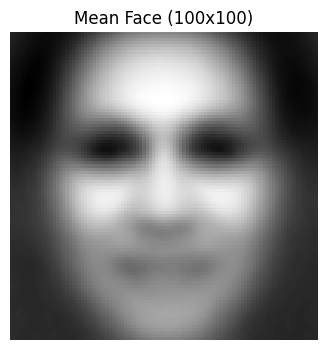

In [8]:
# 👀 Visualizing the Mean Face

# Reshape the mean face vector into 100x100 for visualization
plt.figure(figsize=(4,4))
plt.imshow(mean_face.reshape((100,100)), cmap='gray')
plt.title("Mean Face (100x100)")
plt.axis('off')
plt.show()


# 🔄 Subtracting the Mean Face


Before applying PCA, we need to **center the data** by subtracting the mean face from every image.  
This ensures that PCA captures the **variation between faces** rather than being dominated by the average brightness or intensity of the dataset.  

Mathematically:  
\[
X_t = X - \text{mean\_face}
\]

Where:
- \(X\) = original dataset (flattened images)  
- \(\text{mean\_face}\) = average face vector  
- \(X_t\) = mean-centered data (ready for PCA)


In [9]:
# Subtract data with mean face
X_t = X - mean_face
X_t.shape


(4265, 10000)

# Applying PCA for Eigenfaces


Now that we have mean-centered data (\(X_t\)), we can apply **Principal Component Analysis (PCA)** to extract the most important features of the face images.

### Why PCA?
- Faces are **high-dimensional data** (100 × 100 = 10,000 pixels per image).  
- Not all pixels contribute equally to distinguishing faces.  
- PCA helps reduce dimensionality while keeping only the most **informative features**.  

### Steps:
1. **Compute Principal Components** → Find new axes (Eigenfaces) that capture maximum variance.  
2. **Decide Number of Components** → Use the **Elbow Method** on the explained variance ratio to choose the right number.  
3. **Transform Data** → Project face images into this reduced feature space.

This gives us the **Eigenfaces**, which form the building blocks of face representation in our dataset.


In [10]:
# Apply PCA
pca = PCA(n_components=None, whiten=True, svd_solver='auto')
pca.fit(X_t)


PCA(whiten=True)

# 📊 Explained Variance of Principal Components

Once PCA is applied, each **Principal Component (PC)** explains a certain portion of the variance in the dataset.  
- **Explained Variance Ratio** → tells us how much information (variance) each PC captures.  
- **Cumulative Explained Variance** → shows the total variance captured as we add more components.  

This helps us decide the **optimal number of components** to retain (using the Elbow method).


In [11]:
# Explained variance dataframe
exp_var_df = pd.DataFrame()
exp_var_df['explained_var'] = pca.explained_variance_ratio_
exp_var_df['cum_explained_var'] = exp_var_df['explained_var'].cumsum()
exp_var_df['principal_components'] = np.arange(1, len(exp_var_df) + 1)

exp_var_df.head()


,explained_var,cum_explained_var,principal_components
0,0.252934,0.252934,1
1,0.116089,0.369023,2
2,0.107108,0.476131,3
3,0.051908,0.528039,4
4,0.032371,0.560410,5


---
# 📈 Visualizing Explained Variance (Elbow Method)

To determine the optimal number of Principal Components (PCs), we use the **Elbow Method**:  
- The **Explained Variance plot** shows how much information each PC captures individually.  
- The **Cumulative Explained Variance plot** shows the total variance captured as we add more PCs.  

We typically choose the number of PCs at the "elbow point" → where adding more PCs yields diminishing returns.


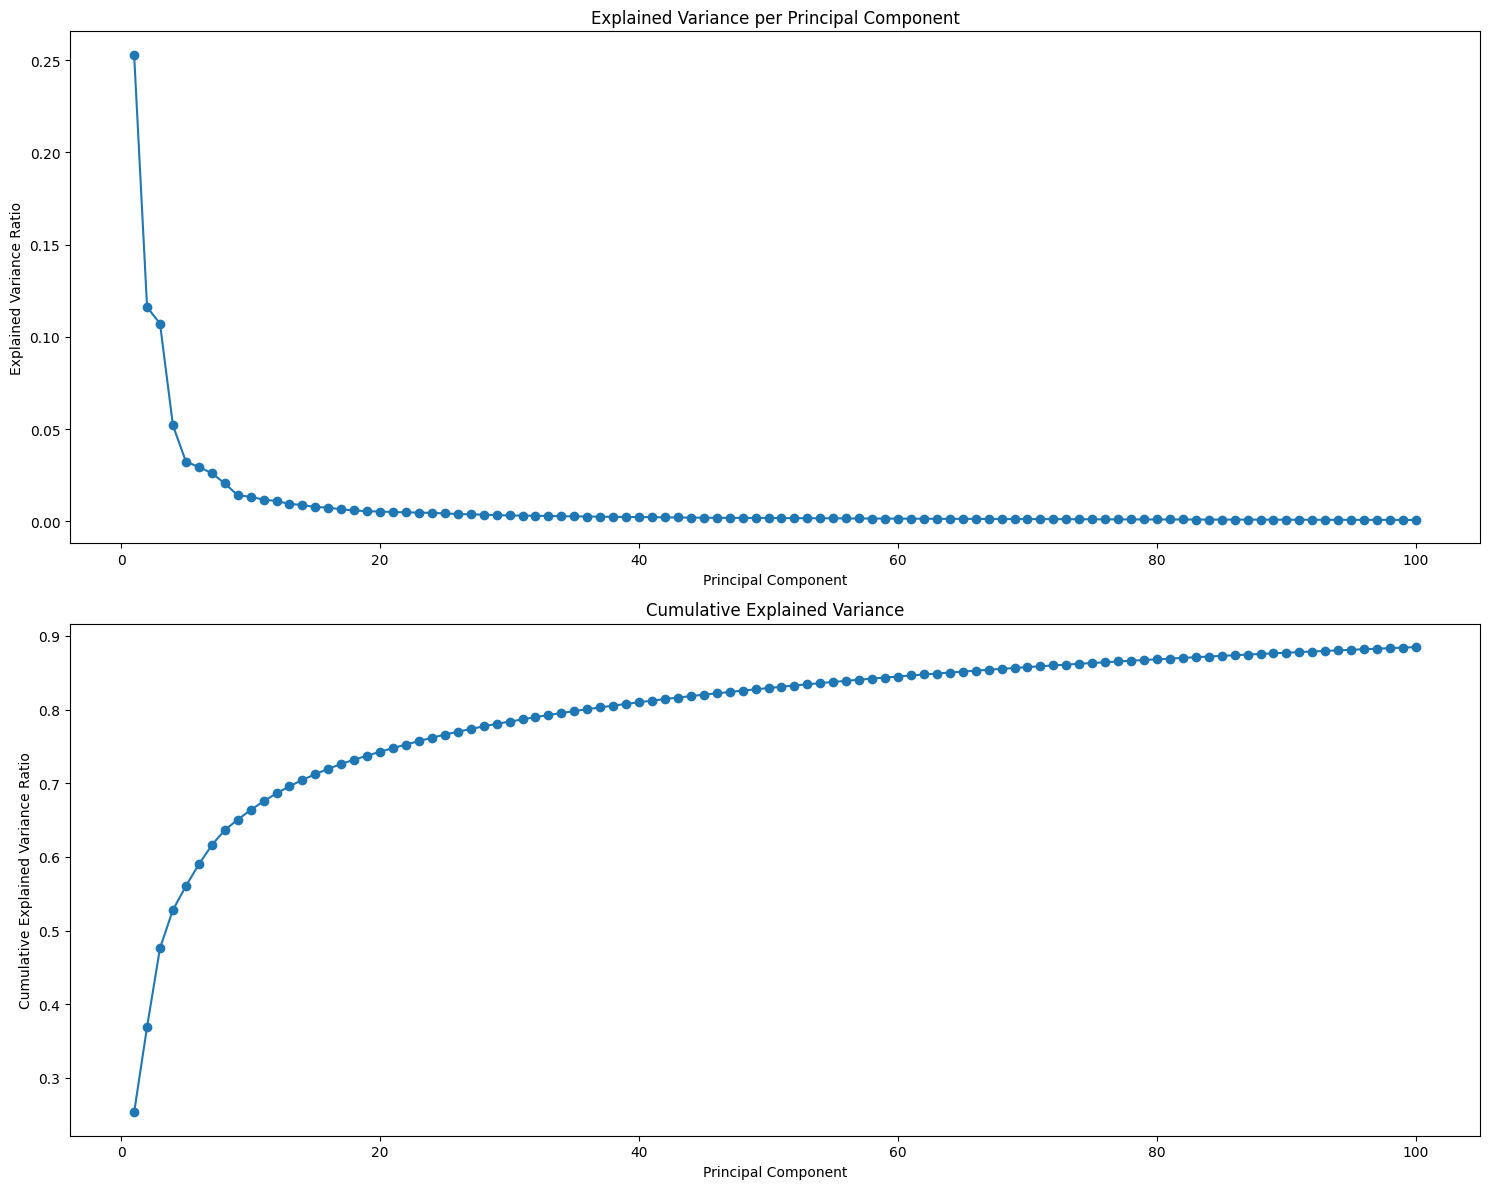

In [12]:
# Set principal component as index
exp_var_df.set_index('principal_components', inplace=True)

# Visualize explained variance and cumulative explained variance
fig, ax = plt.subplots(nrows=2, figsize=(15, 12))

# Individual explained variance
exp_var_df['explained_var'].head(100).plot(kind='line', marker='o', ax=ax[0])
ax[0].set_title("Explained Variance per Principal Component")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

# Cumulative explained variance
exp_var_df['cum_explained_var'].head(100).plot(kind='line', marker='o', ax=ax[1])
ax[1].set_title("Cumulative Explained Variance")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Cumulative Explained Variance Ratio")

plt.tight_layout()
plt.show()


# 📝 Selecting Number of Principal Components


From the explained variance plots, it is clear that:

- With approximately **50 principal components**, we capture around **80% of the total variance** in the dataset.  
- Retaining these components allows us to **significantly reduce dimensionality** while preserving most of the important facial information.  

✅ This subset of components will be used as the **Eigenface feature representation** for each image in subsequent modeling steps.


---
# 🧑‍💻 PCA Transformation with 50 Components

Based on the previous analysis, we will now reduce our dataset to **50 principal components**.  
This will retain most of the important facial features (~80% variance) while **reducing dimensionality**.


In [13]:
# Apply PCA with 50 components
pca_50 = PCA(n_components=50, whiten=True, svd_solver='auto')
pca_data = pca_50.fit_transform(X_t)

# Check the shape of transformed data
print("Transformed Data Shape (Images × 50 PCs):", pca_data.shape)


Transformed Data Shape (Images × 50 PCs): (4265, 50)


# 💾 Saving PCA Features and Labels


After extracting the **Eigenface features** (50 principal components), we save both the features and the target labels for future use:

- `pca_data` → transformed feature matrix (Images × 50 PCs)  
- `y` → corresponding gender labels  

Saving ensures we do **not need to recompute PCA** every time we want to train a model.


In [14]:
# Extract target labels
y = data['gender'].values  

# Save features and labels as a .npz file
np.savez('./data/data_pca_50_target.npz', pca_data=pca_data, y=y)

print("✅ PCA features and labels saved successfully at './data/data_pca_50_target.npz'")


✅ PCA features and labels saved successfully at './data/data_pca_50_target.npz'


# 💾 Saving PCA Model

To reuse the **trained PCA transformation** in future experiments or in deployment,  
we save both the **PCA object** and the **mean face**:

- `pca_50` → contains the principal components (Eigenfaces)  
- `mean_face` → used to center new images before transforming  

This allows new images to be projected into the same Eigenface space consistently.


In [15]:
# Create a dictionary containing PCA and mean face
pca_dict = {'pca': pca_50, 'mean_face': mean_face}

# Save to pickle file
pickle.dump(pca_dict, open('./models/pca_dict.pickle', 'wb'))

print("✅ PCA model and mean face saved successfully at './models/pca_dict.pickle'")

✅ PCA model and mean face saved successfully at './models/pca_dict.pickle'


# 👀 Visualizing Reconstructed Faces (Eigenfaces)

After applying PCA, we can **reconstruct approximate images** from the reduced feature set by inverting the transformation.  
- This helps visualize how much facial information is retained with 50 principal components.  
- The reconstructed faces are an **approximation** of the original images.


In [16]:
# Inverse transform PCA data to reconstruct images
pca_data_inv = pca_50.inverse_transform(pca_data)

# Check the shape of reconstructed data
print("Reconstructed Data Shape:", pca_data_inv.shape)


Reconstructed Data Shape: (4265, 10000)


# 👁 Visualizing a Single Reconstructed Eigenface

We can reshape the first reconstructed image from the PCA-transformed data to **100×100 pixels**  
to visualize how well the reduced 50-component representation captures facial features.


Reconstructed Eigenface Shape: (100, 100)


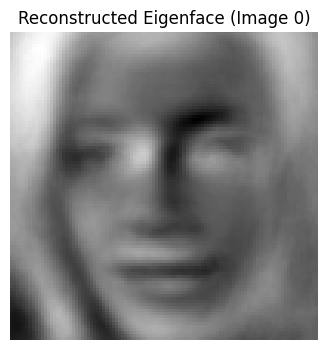

In [17]:
# Reshape the first reconstructed image
eig_img = pca_data_inv[0, :].reshape((100, 100))
print("Reconstructed Eigenface Shape:", eig_img.shape)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(eig_img, cmap='gray')
plt.title("Reconstructed Eigenface (Image 0)")
plt.axis('off')
plt.show()


# 👥 Visualizing Multiple Original and Reconstructed Faces

To better understand how well PCA with 50 components preserves facial information,  
we visualize **40 randomly selected faces** from the dataset:

1. **Original Images** → Shows the raw preprocessed images.  
2. **Reconstructed Eigenfaces** → Shows the corresponding images reconstructed from the PCA-transformed features.  

This comparison helps assess the quality of feature extraction using Eigenfaces.


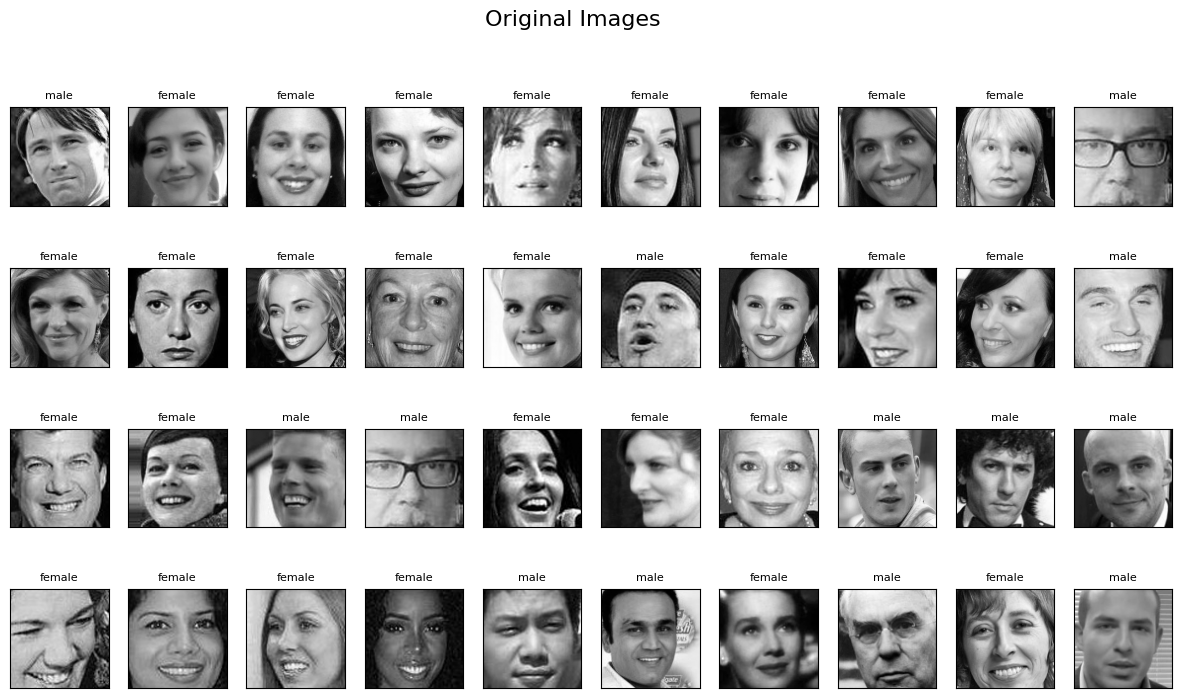

==================== Eigen Images ====================


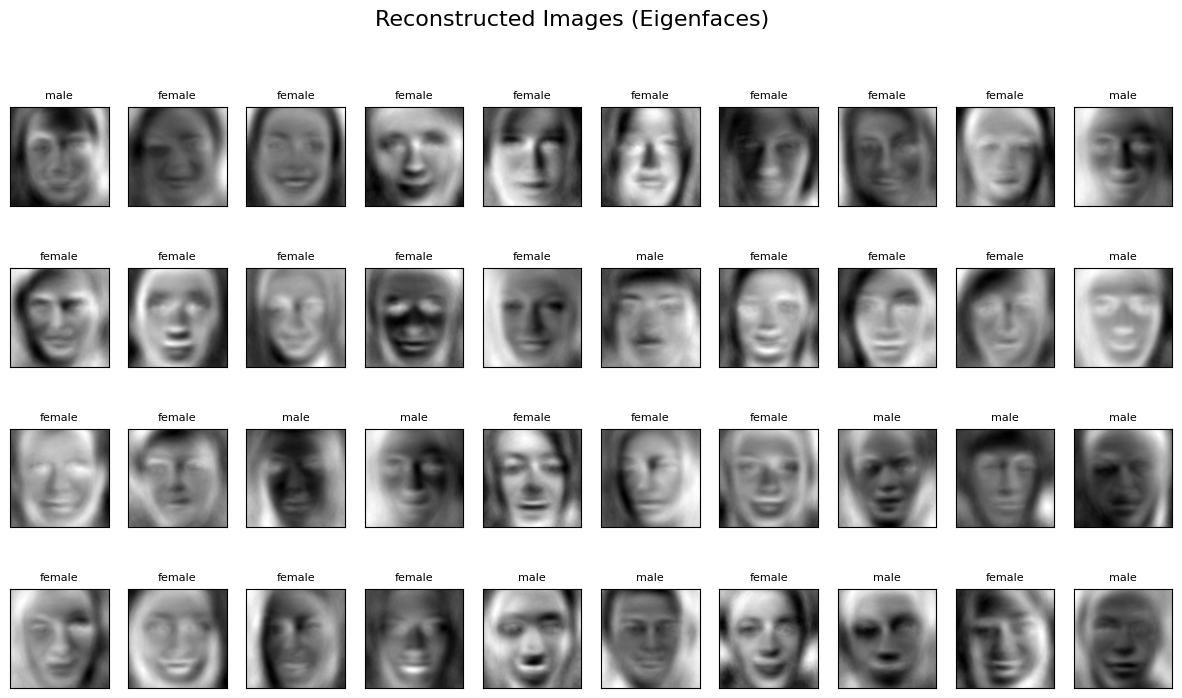

In [18]:
# Set random seed for reproducibility
np.random.seed(1001)

# Select 40 random images
pics = np.random.randint(0, X.shape[0], 40)

# Plot original images
plt.figure(figsize=(15, 8))
for i, pic in enumerate(pics):
    plt.subplot(4, 10, i + 1)
    img = X[pic:pic + 1].reshape(100, 100)
    plt.imshow(img, cmap='gray')
    plt.title(y[pic], fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Original Images", fontsize=16)
plt.show()

# Separator
print("=" * 20 + " Eigen Images " + "=" * 20)

# Plot reconstructed images from PCA
plt.figure(figsize=(15, 8))
for i, pic in enumerate(pics):
    plt.subplot(4, 10, i + 1)
    img = pca_data_inv[pic:pic + 1].reshape(100, 100)
    plt.imshow(img, cmap='gray')
    plt.title(y[pic], fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Reconstructed Images (Eigenfaces)", fontsize=16)
plt.show()


---
# 📝 Conclusion


### Summary of Steps Completed:
1. **Loaded Preprocessed Data**  
   - Grayscale images of size 100×100, flattened and normalized.

2. **Computed Mean Face**  
   - Calculated the average face across all images to center the data for PCA.

3. **Applied PCA (Eigenfaces)**  
   - Subtracted the mean face to obtain mean-centered data.  
   - Applied PCA to extract principal components (Eigenfaces) capturing the main facial variations.

4. **Explained Variance Analysis**  
   - Plotted explained variance and cumulative explained variance.  
   - Determined that **50 principal components** capture ~80% of total variance.

5. **Transformed and Reconstructed Images**  
   - Transformed all images into **50-dimensional feature vectors**.  
   - Reconstructed images to visualize the quality of Eigenface representation.  
   - Visualized multiple original vs reconstructed images to validate feature extraction.

6. **Saved PCA Features and Model**  
   - Saved the PCA-transformed features and labels (`.npz`).  
   - Pickled the PCA model along with the mean face for future use.

---

### 🔜 Next Notebook: 04_FRM_Machine_Learning

In the next notebook, we will:
- Use the **Eigenface features** extracted in this notebook as input for **machine learning models**.  
- Train models such as **SVM, Logistic Regression, or Random Forest** to classify gender from face images.  
- Evaluate model performance using metrics like **accuracy, precision, recall, and confusion matrix**.  
- Save the trained model(s) for deployment in the Flask application.

✅ With the Eigenface features ready, we are now prepared to build and evaluate the **gender classification models** efficiently.
